<a href="https://colab.research.google.com/github/tsachiblau/sparseGANProject/blob/master/GAN_roy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setting up

In [0]:
from keras.optimizers import Adam
import numpy as np

np.random.seed(10)

noise_dim = 100



batch_size = 16
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 5

img_rows, img_cols, channels = 28, 28, 1
sparse_dim = img_rows * img_cols * channels
#sparse_dim = 10
optimizer = Adam(0.0002, 0.5)

import data set

In [19]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1

x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector

np.random.shuffle(x_train)
print(x_train.shape)

(60000, 784)


creating gan:

In [0]:
# generator:
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization

# input: image size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()

    reconstructor.add(Dense(512, input_dim=img_cols*img_rows*channels))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(256))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(noise_dim))
    reconstructor.add(LeakyReLU(0.2))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: image size
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    # remove this to return to FC scheme
    generator.add(Reshape((img_rows, img_cols, channels)))
    #generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator
    
"""
def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator
"""
# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()

discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

fake_image = generator(gan_input)

fake_image_vec = Flatten()(fake_image)  # will enter reconstructor


gan_output = discriminator(fake_image)

vae_output = reconstructor(fake_image_vec)

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd') #todo: consider MAE


gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


train the GAN:

(None, 784)
(None, 100)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss: 0.24623315036296844 		 Generator Loss: 3.267835855484009 		 Reconstructor Loss: 0.9457851648330688 
Epoch: 1 	 Discriminator Loss: 0.2589292526245117 		 Generator Loss: 3.885723829269409 		 Reconstructor Loss: 0.9594258069992065 
Epoch: 2 	 Discriminator Loss: 0.23936159908771515 		 Generator Loss: 3.946578025817871 		 Reconstructor Loss: 1.0347537994384766 
Epoch: 3 	 Discriminator Loss: 0.21601106226444244 		 Generator Loss: 5.366122722625732 		 Reconstructor Loss: 1.0479507446289062 
Epoch: 4 	 Discriminator Loss: 0.26192808151245117 		 Generator Loss: 4.450636386871338 		 Reconstructor Loss: 1.0151227712631226 
Epoch: 5 	 Discriminator Loss: 0.2654881477355957 		 Generator Loss: 3.3728604316711426 		 Reconstructor Loss: 0.9949914216995239 
Epoch: 6 	 Discriminator Loss: 0.21870771050453186 		 Generator Loss: 3.5679547786712646 		 Reconstructor Loss: 1.0137231349945068 
Epoch: 7 	 Discriminator Loss: 0.33633220195770264 		 Generator Loss: 4.90957164764

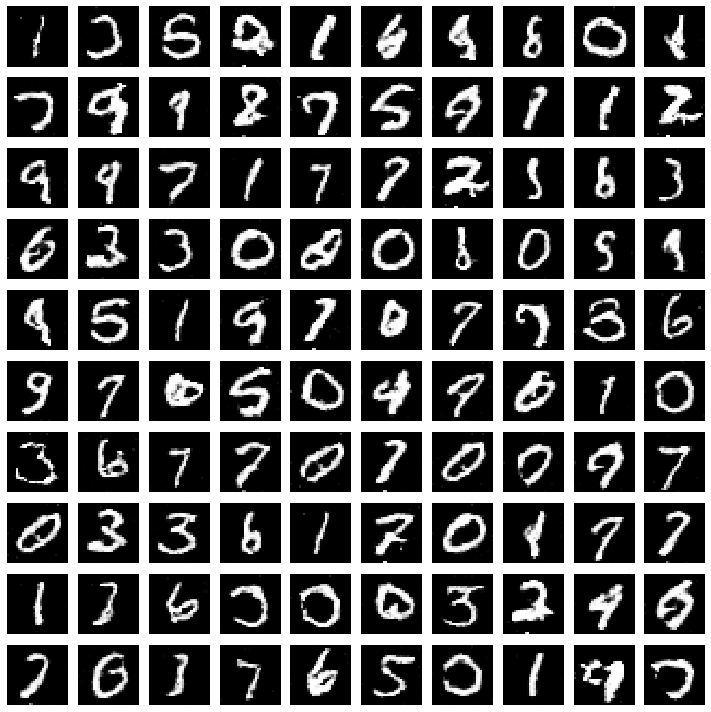

In [0]:
import matplotlib.pyplot as plt


for epoch in range(epochs):  
    for batch in range(steps_per_epoch): 
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        fake_x = generator.predict(noise) # create G(z)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)] # sample real image
        #remove below to return to FC scheme
        real_x = real_x.reshape(fake_x.shape)

        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        # train_on_batch recieves data and desired output
        d_loss_fake = discriminator.train_on_batch(x[:batch_size], disc_y[:batch_size])
        d_loss_real = discriminator.train_on_batch(x[batch_size:-1], disc_y[batch_size:-1])
        # train GAN (descriminator weights are fixed)
        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
        # train reconstructor
        if(batch)
          r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])

        

    print(f'Epoch: {epoch} \t Discriminator Loss: {(d_loss_fake+d_loss_real)/2} \t\t Generator Loss: {g_loss} \t\t Reconstructor Loss: {r_loss} ')


def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)





Train sparse dictionary: *RUN ONLY ONCE*

In [0]:
from sklearn.decomposition import DictionaryLearning
from numpy import loadtxt,savetxt
import matplotlib.pyplot as plt

# init a dictionary learning alg - based on LARS
# TODO - change to all data set and make redundant dictionary
d=DictionaryLearning(n_components=sparse_dim)
# train dictionary
d.fit(x_train[1:2*sparse_dim,:])
dictionary = d.components_
savetxt('dictionary.csv', dictionary, delimiter=',')
# we will download to a local file named dictionary_loaded
#*reconstruct* an image for sanity check
representation_vec = d.transform(x_train[1:2,:])
print(representation_vec.shape)
print(dictionary_loaded2.shape)
dictionary_loaded2 = np.transpose(dictionary_loaded2)
representation_vec = np.transpose(representation_vec)
ans = np.matmul(dictionary_loaded2,representation_vec)

plt.figure()
plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')

plt.figure()
real_im = x_train[1:2,:]
plt.imshow(real_im.reshape((img_rows, img_cols)), cmap='gray')


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=1.481e-03, previous alpha=1.481e-03, with an active set of 22 regressors.
  ConvergenceWarning)


reload trained dictionary from local machine - dictionary_loaded.csv

In [0]:
from numpy import loadtxt,savetxt
from sklearn.decomposition import OrthogonalMatchingPursuit
 
dictionary_loaded2 = loadtxt('dictionary_loaded.csv', delimiter=',')
dictionary_loaded2 = np.array(dictionary_loaded2,dtype=np.float32)
#dictionary_loaded2 = np.eye(sparse_dim,dtype=np.float32)  # format that is used in keras
# the above dict should enable training a regular gan
dictionary_loaded2 = np.transpose(dictionary_loaded2)

In [0]:
L1_weight = 0.1   # Loss = data_fidelity + L1_weight * L1_norm
thr_value = 0.1

In [0]:
# with pursuit and thresholding approach
# generator:
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, ThresholdedReLU
from tensorflow.linalg import matmul, matrix_transpose
from tensorflow.math import abs
# input: sparse vec size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()
    init = RandomNormal(0,stddev=0.02)

    #reconstructor.add(Dense(512, input_dim=img_cols*img_rows*channels))
    reconstructor.add(Dense(512,  kernel_initializer=init, input_dim=sparse_dim))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(256, kernel_initializer=init))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(noise_dim, kernel_initializer=init))
    reconstructor.add(LeakyReLU(0.2))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: sparse vec size
def create_generator():
    generator = Sequential()
    init = RandomNormal(0,stddev=0.02)
    generator.add(Dense(256, kernel_initializer=init, input_dim=noise_dim))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    #generator.add(ReLU())

    generator.add(Dense(512,kernel_initializer=init))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    #generator.add(ReLU())

    generator.add(Dense(1024,kernel_initializer=init,))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    #generator.add(ReLU())

    generator.add(Dense(sparse_dim, kernel_initializer=init))
    generator.add(BatchNormalization())
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()

discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

# G(z) is a sparse vector
sparse_vec = generator(gan_input)   # sparse_dim size - it is thresholded

# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))))(sparse_vec)
# reshape to image size - will be inserted to discriminator
fake_image = Reshape((img_rows, img_cols, channels))(fake_image_vec)

gan_output = discriminator(fake_image)  # the descriminator output
vae_output = reconstructor(sparse_vec)  # the reconstructor output

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd')

# todo - double output double loss
gan = Model(gan_input, [gan_output,sparse_vec])
gan.compile(loss=['binary_crossentropy','mean_absolute_error'], optimizer=optimizer,loss_weights=[1,L1_weight])



2nd approach train

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss_fake: 0.33885765075683594 	 Discriminator Loss_real: 0.0019271124619990587		 Generator Loss: [6.0601473, 5.9875, 0.7264695] 		 Reconstructor Loss: 1.0394171476364136 	 support: 0.0
Epoch: 1 	 Discriminator Loss_fake: 0.3317529559135437 	 Discriminator Loss_real: 0.00024443274014629424		 Generator Loss: [9.857705, 9.7889595, 0.68745506] 		 Reconstructor Loss: 0.9543709754943848 	 support: 0.0
Epoch: 2 	 Discriminator Loss_fake: 0.3316493630409241 	 Discriminator Loss_real: 3.9251288399100304e-05		 Generator Loss: [7.0277367, 6.9764214, 0.51315325] 		 Reconstructor Loss: 0.9632176756858826 	 support: 0.0
Epoch: 3 	 Discriminator Loss_fake: 0.33537185192108154 	 Discriminator Loss_real: 0.003615944180637598		 Generator Loss: [8.310698, 8.251312, 0.5938552] 		 Reconstructor Loss: 0.9722689390182495 	 support: 0.0
Epoch: 4 	 Discriminator Loss_fake: 0.35633939504623413 	 Discriminator Loss_real: 0.07167579978704453		 Generator Loss: [5.2859335, 5.2222958, 0.636

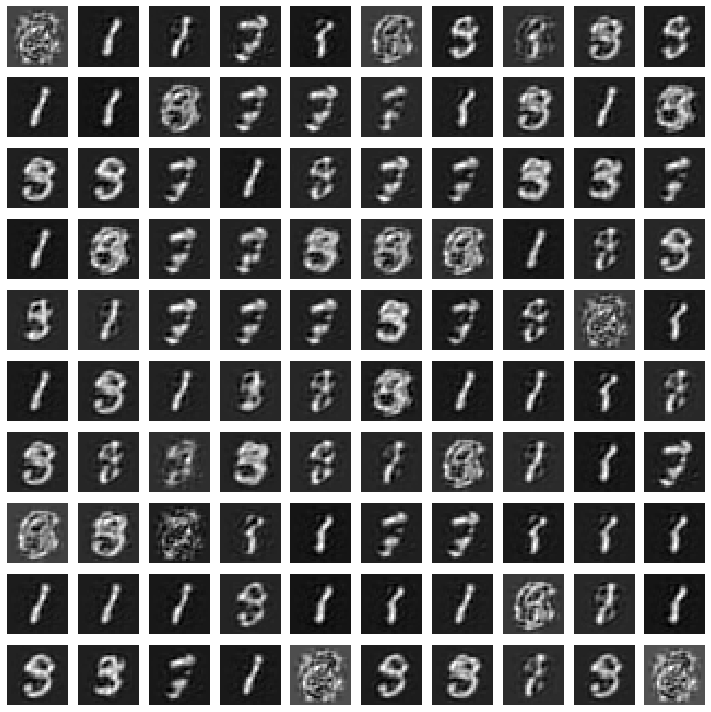

In [102]:
import matplotlib.pyplot as plt

def count_support(sparse_mat):
  return ((batch_size*sparse_dim)-(np.count_nonzero(sparse_mat)))/16


for epoch in range(epochs):  #epochs
    for batch in range(steps_per_epoch):  #steps_per_epoch
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        fake_x = generator.predict(noise) # create G(z)
        # fake is (batch_size,sparse_dim)
        
        fake_x = np.transpose(fake_x)
        # multiply by dict
        fake_x = np.matmul(dictionary_loaded2,fake_x)

        fake_x = np.transpose(fake_x)
        support = count_support(fake_x)
        fake_x = fake_x.reshape(batch_size,img_rows,img_cols,channels)
        # fake_x is of size (batch,rows,cols,channels)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)] # sample real image
        #remove below to return to FC scheme
        real_x = real_x.reshape(fake_x.shape)

        x = np.concatenate((real_x, fake_x))
        # x is of size (2*batch,rows,cols,channels)
        
        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        # train_on_batch recieves data and desired output
        d_loss_fake = discriminator.train_on_batch(x[:batch_size], disc_y[:batch_size])
        d_loss_real = discriminator.train_on_batch(x[batch_size:], disc_y[batch_size:])
        
        # train GAN (descriminator weights are fixed)
        y_gen_1 = np.ones(batch_size)
        y_gen_2 = np.zeros(batch_size * sparse_dim)
        y_gen_2 = y_gen_2.reshape(batch_size,sparse_dim)
        # TODO train the two outputs
        for iter in range(1):
          if(iter==0):
            g_loss = gan.train_on_batch(noise, [y_gen_1,y_gen_2])
          else:
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
            g_loss = gan.train_on_batch(noise, [y_gen_1,y_gen_2])


        # train reconstructor
        r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])

        

    print(f'Epoch: {epoch} \t Discriminator Loss_fake: {d_loss_fake} \t Discriminator Loss_real: {d_loss_real}\t\t Generator Loss: {g_loss} \t\t Reconstructor Loss: {r_loss} \t support: {support}')


def show_images(noise):
    generated_images = generator.predict(noise)
    generated_images = np.matmul(dictionary_loaded2,np.transpose(generated_images))
    generated_images = np.transpose(generated_images)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)